In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Higgs.tools.ImplementationUtils import (
    implementPairDecayLimit,
    fromHB5Table2,
    implementPairProductionLimit,
)
from Higgs import bounds as HB
from Higgs import predictions as HP
from Higgs import Predictions

import os, sys

sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
import MassResolutions as resolution


# CMS 13TeV LHC

## non-res `pp > hSM hSM > gamgam bb` [2011.12373](http://arxiv.org/abs/2011.12373)

In [3]:
df = pd.DataFrame({"m": [125], "obs": 0.67e-3, "exp": 0.45e-3})
limitFile = implementPairProductionLimit(
    "2011.12373",
    {"firstDecay": ["gamgam"], "secondDecay": ["bb"]},
    "p. 18",
    df,
    massResolution={
        "firstParticle": {"absolute": 3, "relative": 0},  # Fig 8
        "secondParticle": {"absolute": 40, "relative": 0},  # bb resolution is bad
    },
)

lim = HB.Limit(limitFile)

pred = Predictions()
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h1.setDecayWidth("gamgam", 1.0)
h1.setMass(125)
h2 = pred.addParticle(HP.NeutralScalar("h2"))
h2.setDecayWidth("bb", 1.0)
h2.setMass(125)
pred.setBsmPairCxn("LHC13", "h1", "h2", 1.0)
res = lim.apply(pred)
print(res)
assert np.isclose(res[0].obsRatio(), 1.0 / df.obs[0])
assert np.isclose(res[0].expRatio(), 1.0 / df.exp[0])


Looks good. Saving this to nonres_LHC13_CMS_137.json
[<Higgs.bounds.AppliedLimit limitId: 201112373, obsRatio: 1492.537, expRatio: 2222.222, for: ["h1", "+", "h2"]>]


# CMS 8TeV LHC

## `H > hSM hSM > gamgambb` [1603.06896](https://arxiv.org/abs/1603.06896)


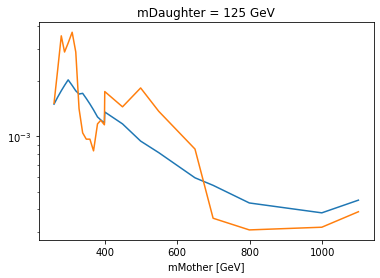

Looks good. Saving this to H_LHC8_CMS_20.json


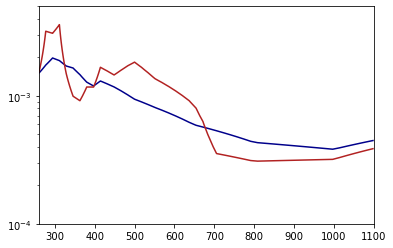

In [2]:
df = fromHB5Table2("06896_H-hh-gagabb_19.7fb-1", "CMS", manuallySelectedM2=[125])
# fb to pb
df.obs /= 1e3
df.exp /= 1e3
limitFile = implementPairDecayLimit(
    1603.06896,
    {
        "production": ["H"],
        "firstDecay": ["gamgam"],
        "secondDecay": ["bb"],
    },
    "Fig. 9 (left)",
    df,
    massResolution={
        "firstDaughter": resolution.gamgam["125"],  # gamgam
        "secondDaughter": resolution.bb["medMass"],  # bb
        "mother": resolution.bb["highMass"],
    },
)

lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h2 = pred.addParticle(HP.NeutralScalar("h2"))
hh.setDecayWidth("h1", "h2", 1.0)
h1.setDecayWidth("bb", 1.0)
h2.setDecayWidth("gamgam", 1.0)
h1.setMass(125)
h2.setMass(125)
hm = np.linspace(260, 1100)
r = np.linspace(1e-4, 5e-3)


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC8", "ggH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
ax.set_yscale("log")
plt.show()
